current_date: 2024-09-13 00:00:00-04:00
current_price: 5626.02001953125
target_date: 2024-12-31 00:00:00
target_price: 6188.622021484375


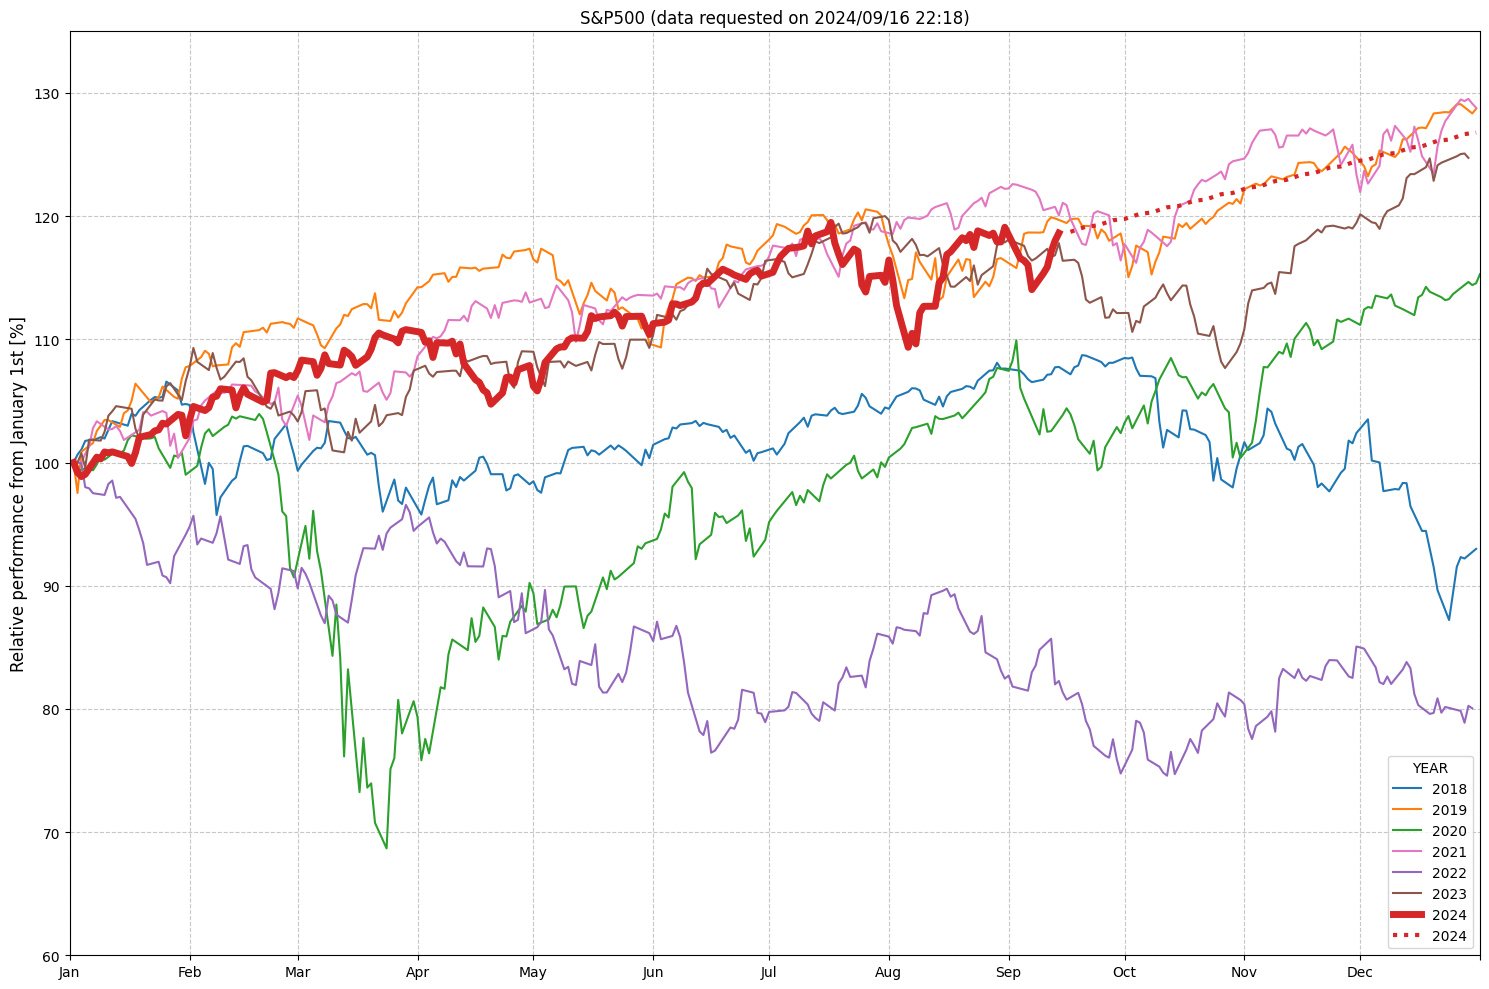

In [82]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# S&P 500のデータを取得
sp500 = yf.Ticker("^GSPC")
start_date = "2018-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
data = sp500.history(start=start_date, end=end_date)

# 想定値の計算
current_date = data.index[-1]
current_price = data['Close'].iloc[-1]
print('current_date: ' + str(current_date))
print('current_price: ' + str(current_price))

# 将来の想定値を設定
target_date = datetime(data.index[-1].year, 12, 31)  # 想定値を達成する将来の日を指定します（例: 2024年12月31日）
target_price = current_price * 1.1  # 例: S&P 500インデックスの想定値
print('target_date: ' + str(target_date))
print('target_price: ' + str(target_price))

# 想定値の推移を計算
target_date = target_date.replace(tzinfo=current_date.tzinfo)
days_to_target = (target_date - current_date).days
daily_growth_rate = (target_price / current_price) ** (1 / days_to_target) - 1
future_dates = pd.date_range(start=current_date + timedelta(days=1), end=target_date, freq='B')
future_prices = [current_price * (1 + daily_growth_rate) ** i for i in range(1, len(future_dates) + 1)]
future_data = pd.Series(future_prices, index=future_dates)

# 各年の最初の取引日の終値を100%として正規化
yearly_data = {}
last_year = datetime.now().year
for year in range(2018, last_year + 1):
    if year == last_year:
        year_data = pd.concat([data[data.index.year == last_year]['Close'], future_data])
    else:
        year_data = data[data.index.year == year]['Close']
    if not year_data.empty:
        base_value = year_data.iloc[0]
        yearly_data[year] = (year_data / base_value) * 100

str_now = datetime.now().strftime("%Y/%m/%d %H:%M")
plt.figure(figsize=(15, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#9467bd', '#8c564b', '#d62728']

for i, (year, values) in enumerate(yearly_data.items()):
    if year == datetime.now().year:
        _l = len(data[data.index.year == last_year]['Close'])
        plt.plot(values.index.dayofyear[0:_l], values[0:_l], label=str(year), color=colors[-1], linewidth=5)
        plt.plot(values.index.dayofyear[_l:], values[_l:], label=str(year), color=colors[-1], linewidth=3, linestyle=':')
    else:
        plt.plot(values.index.dayofyear, values, label=str(year), color=colors[i % len(colors)])

plt.legend(title='YEAR', fontsize=10, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1, 366)
plt.ylim(60, 135)

plt.xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])

plt.ylabel('Relative performance from January 1st [%]', fontsize=12)
plt.title('S&P500 (data requested on ' + str_now + ')', fontsize=12)

plt.tight_layout()
plt.show()